In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [42]:
def parse_ip_port(hex_ip, port):
    """Parses a hexadecimal IP and port to a human-readable string."""
    try:
        # ip = '.'.join(str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2))
        # return f"{ip}:{port}"
        # return f"{ip}"
        
        ip_list=[str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2)]
        return f"Host-{ip_list[2]}"
        
    except ValueError as e:
        print(f"Error parsing IP:Port - {hex_ip}:{port}")
        return "0.0.0.0:0"
    
def plot_flow_rates(flow_packets, ax, xtick_unit, xtick_unit_str, flow_rate_top, flow_rate_bottom,x_left,x_right,title=None):
    flow_rates = defaultdict(list) 
    for (src, dst), data in flow_packets.items():
        data=np.array(data)
        for i in range(1,len(data)):
            flow_bytes = np.sum(data[:i+1,1])
            flow_ns=data[i][0]-data[0][0]
            flow_rate_gbps = (flow_bytes * 8) / (flow_ns / 1e9) / 1e9  # Convert to Mbps
            flow_rates[(src, dst)].append((data[i][0], flow_rate_gbps))
        
    for flow_id, rates in flow_rates.items():
        times, rates = zip(*rates)
        ax.plot(np.array(times)/xtick_unit, rates, label=f"{flow_id[0]} to {flow_id[1]}")
    ax.set_xlabel(f'Time ({xtick_unit_str})')
    ax.set_ylabel('Flow Rate (Gbps)')
    ax.set_xlim(left=x_left,right=x_right)
    # ax.set_ylim(top=flow_rate_top,bottom=flow_rate_bottom)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    if title:
        ax.set_title(title)

def plot_queue_sizes(queue_sizes, ax, xtick_unit, xtick_unit_str, queue_size_top, queue_size_bottom,x_left,x_right,title=None):
    for selected_queue in queue_sizes.keys():
        timestamps, sizes = zip(*queue_sizes[selected_queue])
        ax.plot(np.array(timestamps)/xtick_unit, np.array(sizes) / 1e3, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
    ax.set_xlabel(f'Time ({xtick_unit_str})')
    ax.set_ylabel('Queue Size (KB)')
    # ax.set_ylim(top=queue_size_top, bottom=queue_size_bottom)
    ax.set_xlim(left=x_left,right=x_right)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    if title:
        ax.set_title(title)

def plot_ecn_marks(ecn_marks, ax, xtick_unit, xtick_unit_str, ecn_mark_top, ecn_mark_bottom,x_left,x_right,title=None):
    ecn_mark_rates = defaultdict(list)
    for (src, dst), data in ecn_marks.items():
        data=np.array(data)
        for i in range(1,len(data)):
            ecn_mark_freq = np.sum(data[:i+1,1])
            ecn_mark_ns=data[i][0]-data[0][0]
            ecn_rate_gbps =ecn_mark_freq / (ecn_mark_ns / 1e9) 
            ecn_mark_rates[(src, dst)].append((data[i][0], ecn_rate_gbps))
        
    for flow_id, marks in ecn_mark_rates.items():
        times, rates = zip(*marks)
        ax.plot(np.array(times)/xtick_unit, rates, label=f"{flow_id[0]} to {flow_id[1]}")
    ax.set_xlabel(f'Time ({xtick_unit_str})')
    ax.set_ylabel('ECN Mark Rate ($s^{-1}$)')
    ax.set_xlim(left=x_left,right=x_right)
    # ax.set_ylim(top=ecn_mark_top, bottom=ecn_mark_bottom)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    if title:
        ax.set_title(title)
    
def parse_log_file(shard_seed,data_dir,topo_type,payload_size):
    log_file_path = f'{data_dir}/mix_{topo_type}_s{shard_seed}.log'
    flow_packets = defaultdict(list)
    ecn_marks = defaultdict(list)
    queue_sizes = defaultdict(list)
    target_pkt_type = 'U' if shard_seed < 4 else 'T'
    
    start_time=None
    end_time=None
    with open(log_file_path, 'r') as file:
        for line in file:
            parts = line.split()
            
            node = parts[1].split(':')[1]
            pkt_type = parts[10]
            packet_size = int(parts[-1].split('(')[0])
            
            if pkt_type == target_pkt_type and node == '3' and packet_size in payload_size[target_pkt_type]:
                timestamp_ns = int(parts[0])
                event_type = parts[4]
                
                if event_type == "Enqu":
                    port, queue = map(int, parts[2].split(':'))
                    queue_size = float(parts[3])
                    queue_sizes[(node, port, queue)].append((timestamp_ns, queue_size))
                    if start_time is None:
                        start_time=timestamp_ns
                    end_time=timestamp_ns
                elif event_type == "Dequ":
                    src = parse_ip_port(parts[6], parts[8])
                    dst = parse_ip_port(parts[7], parts[9])
                    flow_packets[(src, dst)].append((timestamp_ns, packet_size))
                    ecn_marked = 1 if parts[5].split(':')[1] != '0' else 0
                    ecn_marks[(src, dst)].append((timestamp_ns, ecn_marked))
    return flow_packets, queue_sizes, ecn_marks,start_time,end_time

CC_DICT = {
    # "dctcp": 8,
    "dcqcn_paper_vwin": 1,
    "hp": 3,
    "timely_vwin": 7,
    "powertcp": 2,
    "tcp_bbr": 15,
    "tcp_bic": 16,
    "tcp_cubic": 17,
    "tcp_dctcp": 18,
    "tcp_high_speed": 19,
    "tcp_htcp": 20,
    "tcp_hybla": 21,
    "tcp_illinois": 22,
    "tcp_led_bat": 23,
    "tcp_lp": 24,
    "tcp_scalable": 25,
    "tcp_vegas": 26,
    "tcp_veno": 27,
    "tcp_westwood": 28,
    "tcp_yeah": 29,
    "tcp_linux_reno": 30
}
seed_to_cc=list(CC_DICT.keys())
data_dir = "/data2/lichenni/path_cc20_test/shard0_nflows1_nhosts3"
bw_bottleneck = 10
pd_bottleneck = 1000
payload_size = {'U': [1048,1056,1090], 'T': [1066]}
topo_type = f"topo-pl-3-{bw_bottleneck}-{pd_bottleneck}"
flow_rate_bottom = 0
flow_rate_top = 10
queue_size_top = None
queue_size_bottom = 0
ecn_mark_top = None
ecn_mark_bottom = 0.0
drop_top = 1000  # Maximum value for the y-axis
drop_bottom = 0.0  # Minimum value for the y-axis

xtick_unit = 1e9
xtick_unit_str = 's'

Start time: 1000006128, End time: 1001720736


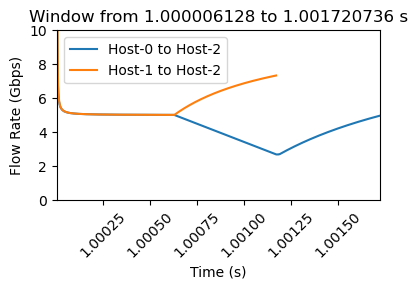

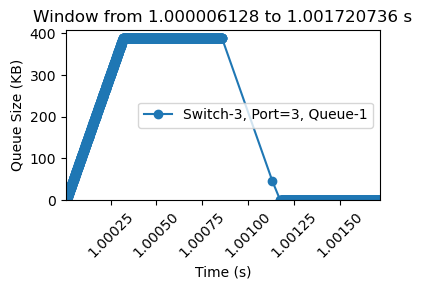

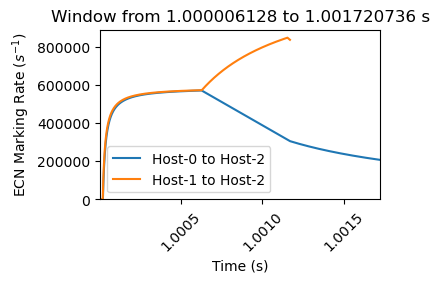

No drop events found in the log file. Stopping execution.


In [8]:
shard_seed=10
flow_packets, queue_sizes, ecn_marks,start_time,end_time = parse_log_file(shard_seed,data_dir,topo_type,payload_size)

print(f"Start time: {start_time}, End time: {end_time}")
# x_left=(start_time+end_time)//2/xtick_unit
# x_right=x_left+xlim_range/xtick_unit
x_left=start_time/xtick_unit
x_right=end_time/xtick_unit
    
flow_rates = defaultdict(list) 
for (src, dst), data in flow_packets.items():
    data=np.array(data)
    for i in range(1,len(data)):
        flow_bytes = np.sum(data[:i+1,1])
        flow_ns=data[i][0]-data[0][0]
        flow_rate_gbps = (flow_bytes * 8) / (flow_ns / 1e9) / 1e9  # Convert to Mbps
        flow_rates[(src, dst)].append((data[i][0], flow_rate_gbps))

# Plot flow rates over time for a selected flow (for simplicity, plot the first flow)
plt.figure(figsize=(4, 3))
# Iterate over each flow and plot its flow rate over time
for flow_id, rates in flow_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times)/xtick_unit, rates, label=f"{flow_id[0]} to {flow_id[1]}")

plt.xlabel(f'Time ({xtick_unit_str})')
plt.ylabel('Flow Rate (Gbps)')
plt.xlim(left=x_left,right=x_right)
plt.ylim(top=flow_rate_top,bottom=flow_rate_bottom)
plt.title(f'Window from {x_left} to {x_right} {xtick_unit_str}')
plt.legend()  # Adjust legend placement
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


plt.figure(figsize=(4, 3))
# Plot queue size over time for a specific queue (for simplicity, plot the first queue)
for selected_queue in queue_sizes.keys():
    timestamps, queue_sizes_tmp = zip(*queue_sizes[selected_queue])
    plt.plot(np.array(timestamps)/xtick_unit, np.array(queue_sizes_tmp) / 1e3, '-o', label=f"Switch-{selected_queue[0]}, Port={selected_queue[1]}, Queue-{selected_queue[2]}")
plt.xlabel(f'Time ({xtick_unit_str})')
plt.ylabel('Queue Size (KB)')
plt.xlim(left=x_left,right=x_right)
plt.ylim(top=queue_size_top,bottom=queue_size_bottom)
plt.title(f'Window from {x_left} to {x_right} {xtick_unit_str}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate ECN marking rate
ecn_mark_rates = defaultdict(list)
for (src, dst), data in ecn_marks.items():
    data=np.array(data)
    for i in range(1,len(data)):
        ecn_mark_freq = np.sum(data[:i+1,1])
        ecn_mark_ns=data[i][0]-data[0][0]
        ecn_rate_gbps =ecn_mark_freq / (ecn_mark_ns / 1e9) 
        ecn_mark_rates[(src, dst)].append((data[i][0], ecn_rate_gbps))
        
# Plot ECN marking rate over time for a selected flow
plt.figure(figsize=(4, 3))
for flow_id, rates in ecn_mark_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times)/xtick_unit, rates, label=f"{flow_id[0]} to {flow_id[1]}")
plt.xlabel(f'Time ({xtick_unit_str})')
plt.ylabel('ECN Marking Rate ($s^{-1}$)')
plt.xlim(left=x_left,right=x_right)
plt.ylim(top=ecn_mark_top, bottom=ecn_mark_bottom)
plt.title(f'Window from {x_left} to {x_right} {xtick_unit_str}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Read the log file and extract drop events with node, port, and queue information
log_file_path = f'{data_dir}/pdrop_{topo_type}_s{shard_seed}.txt'
drop_events = []
with open(log_file_path, 'r') as file:
    for line in file:
        if 'Drop: queue' in line:
            parts = line.split()
            timestamp = int(parts[0])
            node_id = int(parts[1])
            port_queue_part = parts[3].split(':')[1]  # Extract "queue:1,3" part
            port = int(port_queue_part.split(',')[0])
            queue = int(port_queue_part.split(',')[1])
            drop_events.append((timestamp, node_id, port, queue))

# Check if the drop_events list is empty
# Check if the drop_events list is empty
if not drop_events:
    print("No drop events found in the log file. Stopping execution.")
else:
    # Dictionary to store drop frequency for each (node, port, queue) combination
    drop_frequency = defaultdict(list)

    # Iterate over drop events and calculate drop frequency for each time window and combination
    for timestamp, node_id, port, queue in drop_events:
        key = (node_id, port,queue)
        drop_frequency[key].append((timestamp,1))

    drop_freq_rates = defaultdict(list)
    for (node_id, port,queue), data in drop_frequency.items():
        start_time = data[0][0]
        data=np.array(data)
        for i in range(1,len(data)):
            drop_freq = np.sum(data[:i+1,1])
            drop_ns=data[i][0]-start_time
            drop_rate_gbps =drop_freq / (drop_ns / 1e9)  # Convert to Mbps 
            drop_freq_rates[(node_id, port,queue)].append((data[i][0], drop_rate_gbps))
        
    # Plot drop frequency over time for each unique (node, port, queue) combination
    plt.figure(figsize=(4, 3))
    # for (node_id, port, queue), time_buckets in drop_frequency.items():
    for selected_queue in drop_freq_rates.keys():
        timestamps, mean_sizes = zip(*drop_freq_rates[selected_queue])
        plt.figure(figsize=(4, 3))
        # plt.plot(np.array(timestamps) / 1e9, np.array(mean_sizes) / 1024, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
        plt.plot(np.array(timestamps)/xtick_unit, np.array(mean_sizes), '-o', label=f"Switch-{selected_queue[0]}, Port={selected_queue[1]}, Queue-{selected_queue[2]}")

    plt.xlabel('Time (seconds)')
    plt.ylabel('Drop Frequency ($s^{-1}$)')
    plt.title(f'Packet Drop Frequency from {x_left} to {x_right} {xtick_unit_str}')
    plt.yscale('log')
    plt.ylim(top=drop_top, bottom=drop_bottom)
    plt.legend()
    plt.tight_layout()
    plt.show()

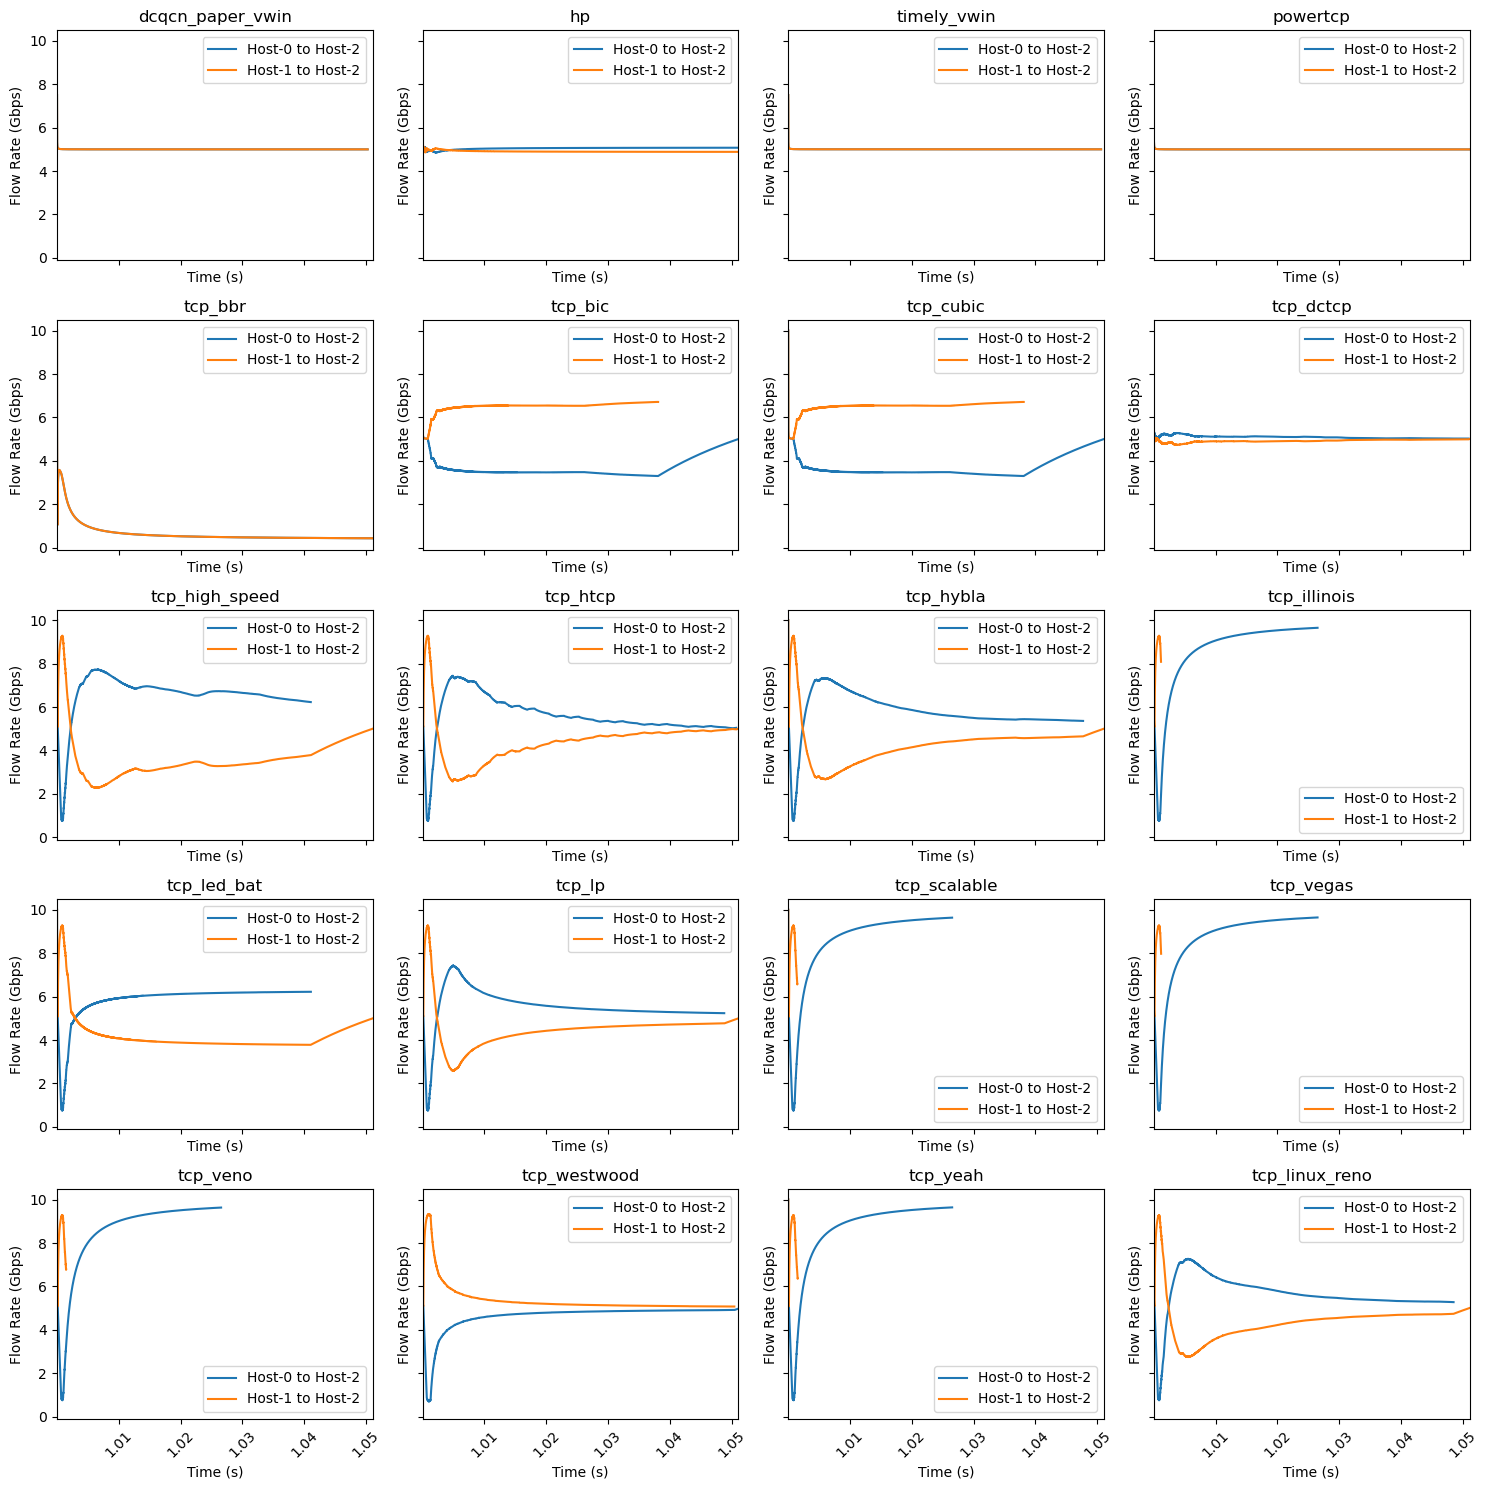

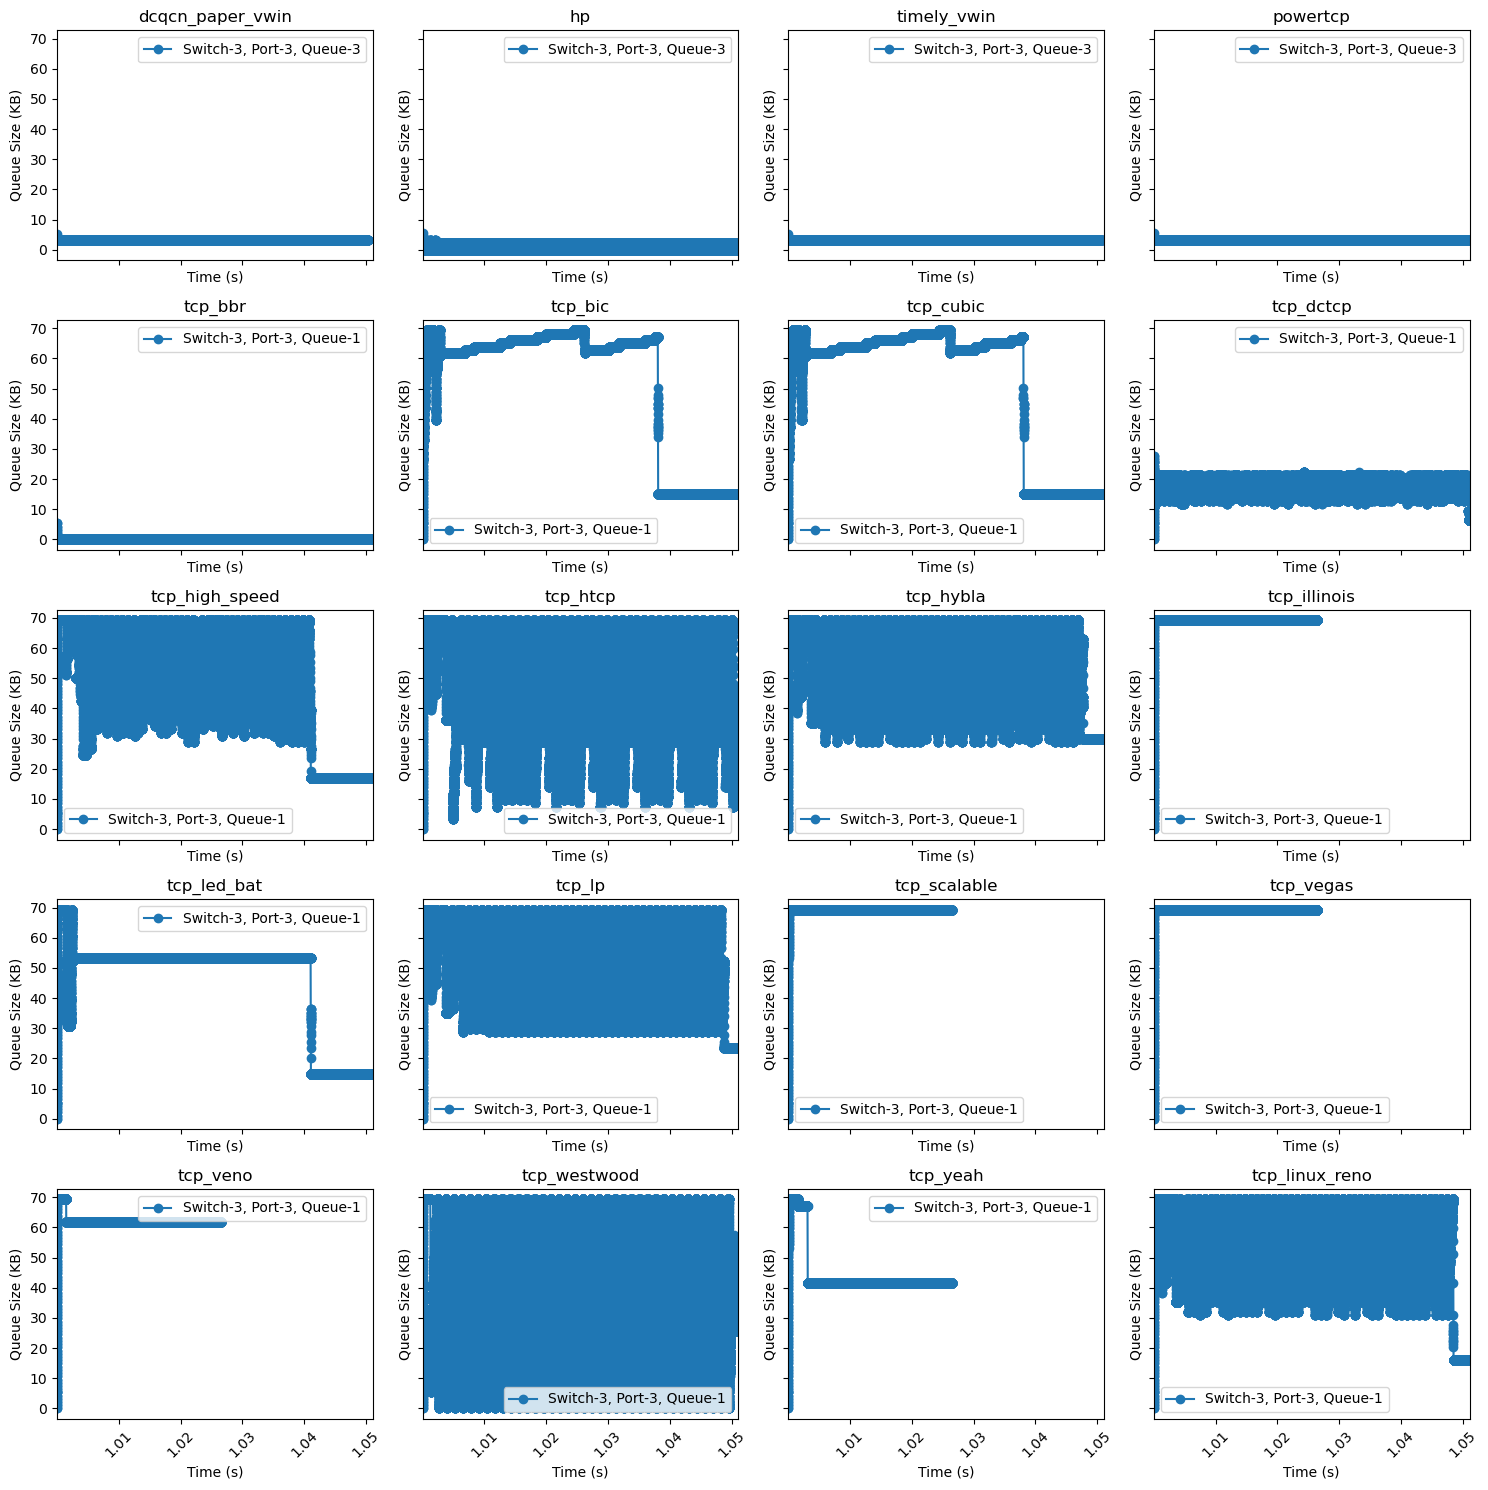

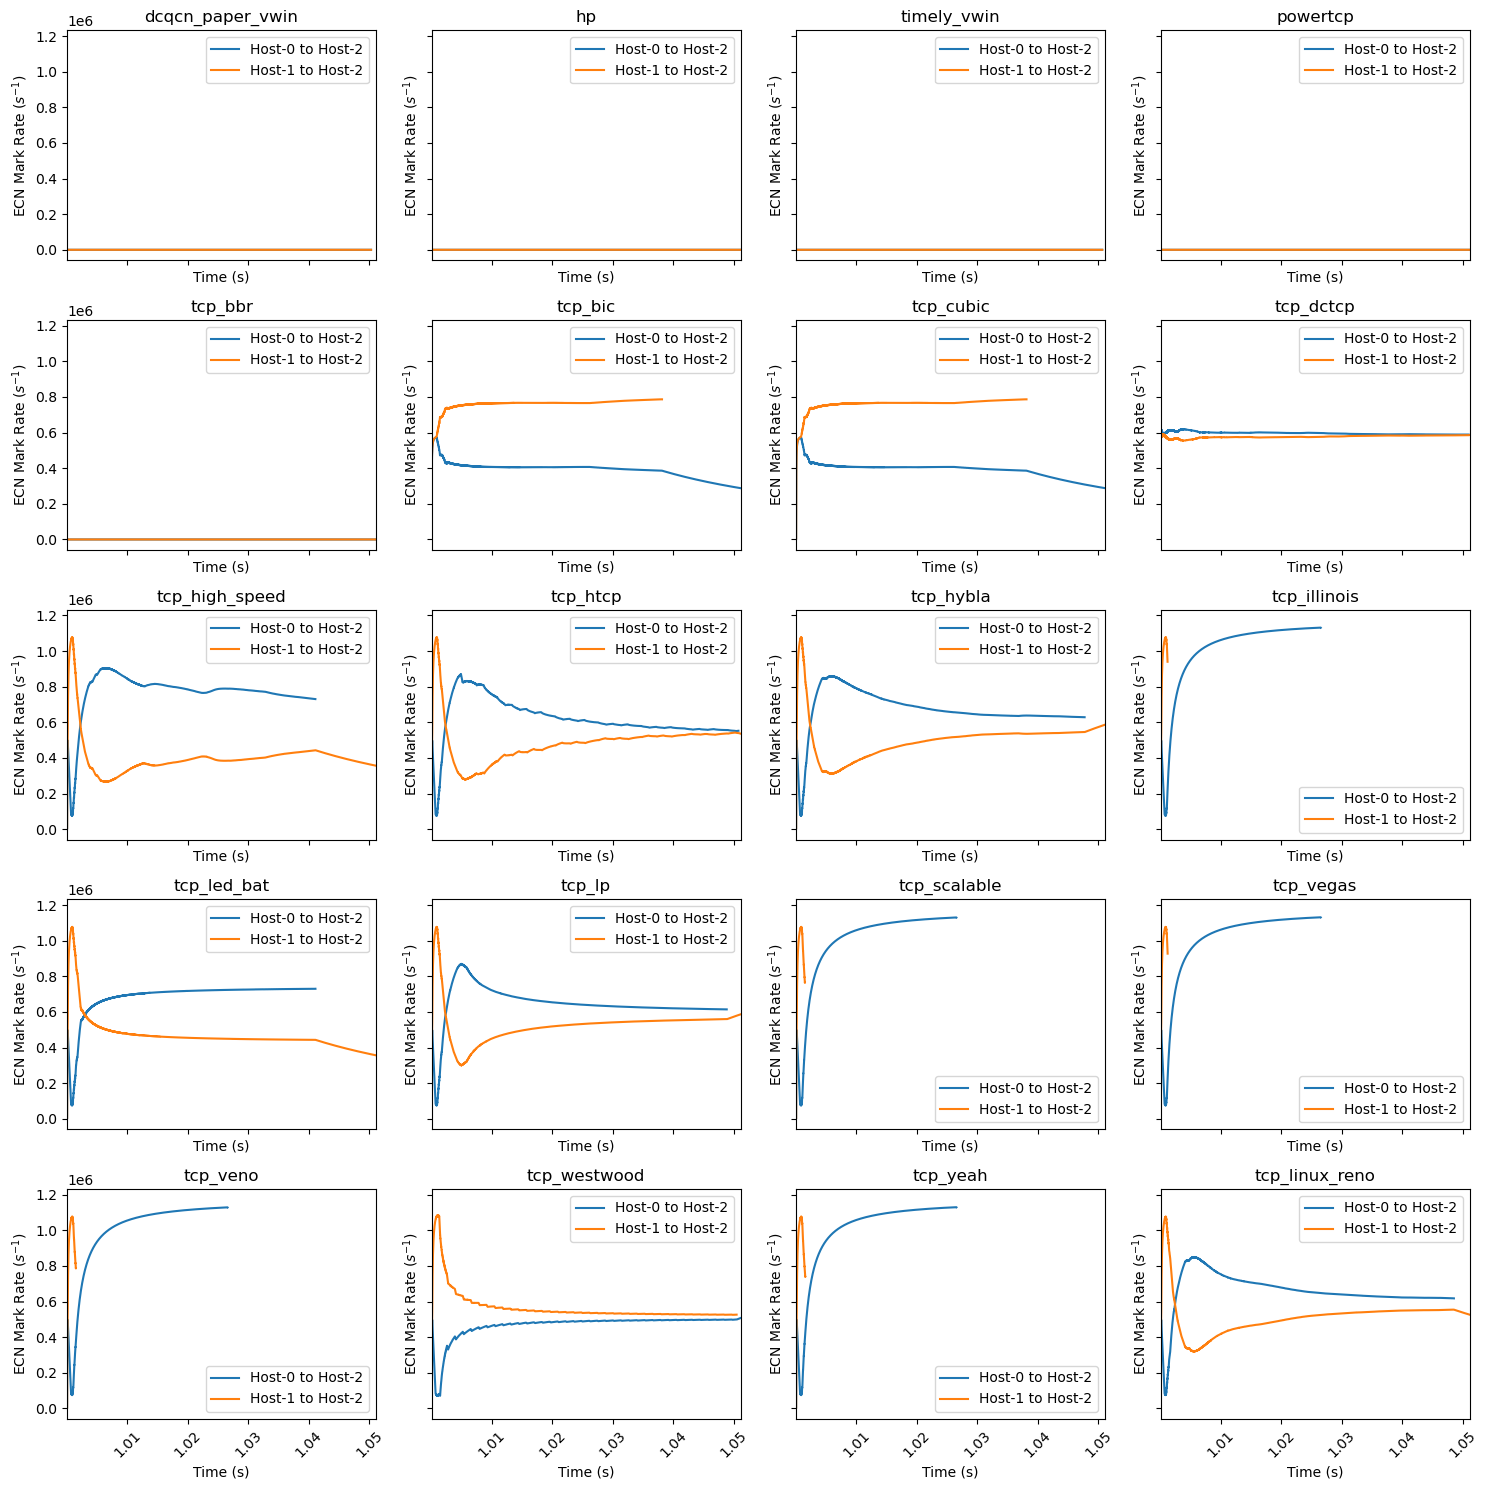

In [43]:
# Constants and setup

# Initialize plots
fig_flow, axs_flow = plt.subplots(5, 4, figsize=(15, 15), sharex=True, sharey=True)
fig_queue, axs_queue = plt.subplots(5, 4, figsize=(15, 15), sharex=True, sharey=True)
fig_ecn, axs_ecn = plt.subplots(5, 4, figsize=(15, 15), sharex=True, sharey=True)

# Loop through each shard seed
for i in range(20):
    flow_packets, queue_sizes, ecn_marks, start_time, end_time = parse_log_file(i, data_dir, topo_type, payload_size)
    
    x_left=start_time/xtick_unit
    x_right=end_time/xtick_unit
    
    # Convert lists to data needed for plotting
    # Simplification: Just using the raw data as-is for this example
    ax_flow = axs_flow.flatten()[i]
    ax_queue = axs_queue.flatten()[i]
    ax_ecn = axs_ecn.flatten()[i]

    # Plot data
    plot_flow_rates(flow_packets, ax_flow, xtick_unit, xtick_unit_str, flow_rate_top, flow_rate_bottom,x_left,x_right,title=f"{seed_to_cc[i]}")
    plot_queue_sizes(queue_sizes, ax_queue, xtick_unit, xtick_unit_str, queue_size_top, queue_size_bottom,x_left,x_right,title=f"{seed_to_cc[i]}")
    plot_ecn_marks(ecn_marks, ax_ecn, xtick_unit, xtick_unit_str, ecn_mark_top, ecn_mark_bottom,x_left,x_right,title=f"{seed_to_cc[i]}")

# Show plots
fig_flow.tight_layout()
fig_queue.tight_layout()
fig_ecn.tight_layout()

fig_flow.show()
fig_queue.show()
fig_ecn.show()
